In [1]:
!pip install PyPokerEngine

     |████████████████████████████████| 51kB 6.2MB/s  eta 0:00:01
  Created wheel for PyPokerEngine: filename=PyPokerEngine-1.0.1-cp36-none-any.whl size=34034 sha256=82e71e9f8a145e52048211ebf5bf227cc38b5e0f6038e6c4f0775c8d02cb78ed
  Stored in directory: /root/.cache/pip/wheels/76/e8/1f/1fb60c7f272ecd622e92e1d7b999d5123cc44f43884457ac7c
Successfully built PyPokerEngine


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.players import BasePokerPlayer
from players import FishPlayer, RandomPlayer, HonestPlayer

In [2]:
config = setup_config(max_round=5, initial_stack=100, small_blind_amount=5)
config.register_player(name="p1", algorithm=FishPlayer())
config.register_player(name="p2", algorithm=RandomPlayer())
game_result = start_poker(config, verbose=1)
game_result

Started the round 1
Street "preflop" started. (community card = [])
"p2" declared "raise:79"
"p1" declared "call:79"
Street "flop" started. (community card = ['C8', 'CA', 'DQ'])
"p2" declared "raise:12"
"p1" declared "call:12"
Street "turn" started. (community card = ['C8', 'CA', 'DQ', 'DA'])
"p2" declared "raise:-1"
"['p1']" won the round 1 (stack = {'p1': 191, 'p2': 9})


{'rule': {'initial_stack': 100,
  'max_round': 5,
  'small_blind_amount': 5,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'p1',
   'uuid': 'zdybeqfucazmspvothdmum',
   'stack': 191,
   'state': 'participating'},
  {'name': 'p2',
   'uuid': 'ocgspnihgicboxznnaztfq',
   'stack': 0,
   'state': 'folded'}]}

# Encoder card

Use one hot encoding here. The `encoder` dictionary to convert card text label to distinct numbers. `tf.one_hot()` is later used to convert numbers to one-hot vectors

In [3]:
suites = ('H', 'C', 'S', 'D')
faces = [x for x in range(2,10)] + ['T', 'J', 'Q', 'K', 'A']

encoder = {}
i = 0

for s in suites:
    for f in faces:
        encoder[f'{s}{f}'] = i
        i += 1

len(encoder)

52

# ML model definition



In [4]:
def create_model():
    hole_cards = tf.keras.Input(shape=(2,52,), name='hole_cards')
    community_cards = tf.keras.Input(shape=(5,52,), name='community_cards')
    stacks_history = tf.keras.Input(shape=(32,2,), name='stacks_history')
    
    cards = tf.keras.layers.concatenate([hole_cards, community_cards], axis=1)
    cards = tf.keras.layers.Flatten()(cards)
    stacks = tf.keras.layers.LSTM(32)(stacks_history)
    
    cards_dense = tf.keras.layers.Dense(50, activation='relu')(cards)
    cards_dense = tf.keras.layers.Dense(10, activation='relu')(cards)
    x = tf.keras.layers.concatenate([cards_dense, stacks])
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    
    action = tf.keras.layers.Dense(3, activation='softmax', name='action')(x)
#     amount = tf.keras.layers.Dense(1, activation='sigmoid', name='amount')(x)
    
    model = tf.keras.Model(
        inputs=[hole_cards, community_cards, stacks_history],
        outputs=action
    )
    
    return model

testmodel = create_model()
testmodel.summary()

hole = ['HA', 'S4']
community = ['ST', 'HJ', 'HQ', 'HK', 'S9']

hole = [encoder[x] for x in hole]
community = [encoder[x] for x in community]

hole = tf.one_hot(hole, 52)
hole = tf.expand_dims(hole, axis=0)

community = tf.one_hot(community, 52)
community = tf.expand_dims(community, axis=0)

stacks = np.random.randint(10, 100, (32,2))
stacks = np.expand_dims(stacks, axis=0)

action = testmodel.predict([hole, community, stacks])
print('action: ', action)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hole_cards (InputLayer)         [(None, 2, 52)]      0                                            
__________________________________________________________________________________________________
community_cards (InputLayer)    [(None, 5, 52)]      0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 7, 52)        0           hole_cards[0][0]                 
                                                                 community_cards[0][0]            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 364)          0           concatenate[0][0]     

In [5]:
# game parameters
INITIAL_STACK = 1000

In [6]:
class ThienPlayer(BasePokerPlayer):
    def __init__(self, name, model):
        self.name = name
        self.model = model
        self.stacks_history = np.ones((32,2))*INITIAL_STACK
        self.state_history = []
        self.action_history = []
        self.payoff_history = []
    
    def declare_action(self, valid_actions, hole_card, round_state):
        round_count = round_state['round_count'] % 32
        street = round_state['street']
        if street == 'preflop':
            return valid_actions[1]['action'], valid_actions[1]['amount']
        
        hole = [encoder[x] for x in hole_card]
        community = [encoder[x] for x in round_state['community_card']]
        community += [-1] * (5-len(community))
        
        hole = tf.one_hot(hole, 52)
        hole = tf.expand_dims(hole, axis=0)

        community = tf.one_hot(community, 52)
        community = tf.expand_dims(community, axis=0)
            
        for x in round_state['seats']:
            if x['name'] == self.name:
                self.stacks_history[round_count, 0] = x['stack']
                self.payoff_history.append(x['stack'] - self.stacks_history[(round_count-1+32)%32, 0]) 
            else:
                self.stacks_history[round_count, 1] = x['stack']
        
        stacks_history = np.vstack([self.stacks_history[round_count:], self.stacks_history[:round_count]])
        stacks_history = np.expand_dims(stacks_history, axis=0)
        stacks_history = tf.convert_to_tensor(stacks_history)
        
        state = [hole, community, stacks_history]
        self.state_history.append(state)
        
        action = self.model.predict(state)[0]
        
        action = np.random.choice(3, p=action)
        self.action_history.append(action)
        
        if action < 2:
            amount = valid_actions[action]['amount']
        else:
            amount = valid_actions[action]['amount']['max']//5
        
        return valid_actions[action]['action'], amount

    def receive_game_start_message(self, game_info):
        pass
    
    def receive_round_start_message(self, round_count, hole_card, seats):
        pass
    
    def receive_street_start_message(self, street, round_state):
        pass
    
    def receive_game_update_message(self, action, round_state):
        pass
    
    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

In [7]:
model = create_model()
player1 = ThienPlayer('p1', model)
player2 = ThienPlayer('p2', model)

config = setup_config(max_round=100, initial_stack=INITIAL_STACK, small_blind_amount=5)
config.register_player(name="p1", algorithm=player1)
config.register_player(name="p2", algorithm=player2)
game_result = start_poker(config, verbose=0)
game_result

{'rule': {'initial_stack': 1000,
  'max_round': 100,
  'small_blind_amount': 5,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'p1',
   'uuid': 'fhapncwfmqfmqggtcwwnov',
   'stack': 1992,
   'state': 'participating'},
  {'name': 'p2',
   'uuid': 'kuaopvtkkkadgkxlpxgjyy',
   'stack': 0,
   'state': 'folded'}]}

In [8]:
print(player1.payoff_history)
print(player2.payoff_history)

[-10.0, -10.0, -20.0, 10.0, -10.0, -206.0, 196.0, -10.0, -10.0, -10.0, 10.0, -10.0, -10.0, -10.0, -10.0, -10.0, 176.0, 10.0, -10.0, 10.0, -10.0, -10.0, 196.0, 10.0, 164.0, 370.0, 370.0, 248.0, 248.0, 151.0, 609.0, 288.0, 652.0, -10.0, 930.0, -10.0, -10.0, 22.0, 22.0, 942.0, 972.0]
[-10.0, 10.0, -10.0, -10.0, 10.0, -186.0, -10.0, -206.0, -186.0, -186.0, -186.0, -186.0, -186.0, 10.0, 10.0, -10.0, -10.0, -10.0, 10.0, -10.0, 10.0, 10.0, -10.0, -10.0, -10.0, -164.0, -380.0, -10.0, -132.0, -229.0, -10.0, -10.0, -331.0, -10.0, -940.0, -940.0, -940.0, -952.0, -10.0, 10.0, -10.0, -10.0, -10.0, -10.0]


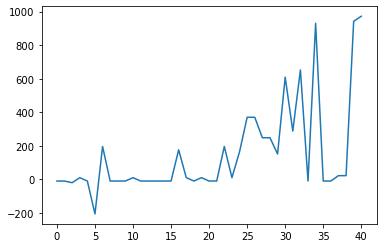

In [9]:
n = len(player1.payoff_history)
plt.plot(np.arange(n), player1.payoff_history)

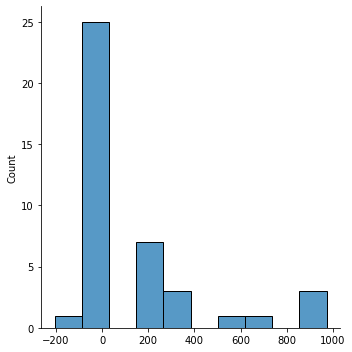

In [10]:
sns.displot(player1.payoff_history)

In [11]:
hole = []
community = []
stack = []
for state in player1.state_history:
    hole.append(state[0])
    community.append(state[1])
    stack.append(state[2])
    
tf.stack(hole, axis=1)[0]

<tf.Tensor: shape=(41, 2, 52), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [12]:
def select_train_data(states, actions, payoffs, percentile=70):
    hole = []
    community = []
    stack = []
    
    for state in states:
        hole.append(state[0])
        community.append(state[1])
        stack.append(state[2])
    
    hole = tf.stack(hole, axis=1)[0]
    community = tf.stack(community, axis=1)[0]
    stack = tf.stack(stack, axis=1)[0]
        
    actions = np.array(actions)
    payoffs = np.array(payoffs)
    
    threshold = np.percentile(payoffs, q=percentile)
    
    select = (payoffs >= threshold)
    
    return hole[select], community[select], stack[select], actions[select]

train_hole, train_community, train_stack, train_actions = select_train_data(player1.state_history, player1.action_history, player1.payoff_history)
train_hole

<tf.Tensor: shape=(13, 2, 52), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [14]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['acc']
)
model.fit([train_hole, train_community, train_stack], train_actions, epochs=10, batch_size=128)

Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.9262 - acc: 0.5385
Epoch 2/10
1/1 [==============================] - 0s 1ms/step - loss: 0.9075 - acc: 0.5385
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.8925 - acc: 0.6154
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.8774 - acc: 0.6154
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.8613 - acc: 0.6923
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.8443 - acc: 0.6923
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 0.8272 - acc: 0.6923
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.8105 - acc: 0.6923
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7939 - acc: 0.6923
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.7752 - acc: 0.6923


In [15]:
def test_players(player1, player2, max_round=100):
    config = setup_config(max_round=max_round, initial_stack=INITIAL_STACK, small_blind_amount=5)
    config.register_player(name="p1", algorithm=player1)
    config.register_player(name="p2", algorithm=player2)
    game_result = start_poker(config, verbose=0)
    return game_result

player_trained = ThienPlayer('p1', model)
test_players(player_trained, HonestPlayer())

{'rule': {'initial_stack': 1000,
  'max_round': 100,
  'small_blind_amount': 5,
  'ante': 0,
  'blind_structure': {}},
 'players': [{'name': 'p1',
   'uuid': 'rfuvezkulivmtemhvmubuu',
   'stack': 168,
   'state': 'participating'},
  {'name': 'p2',
   'uuid': 'pujrwpslagytowsfwnompq',
   'stack': 1832,
   'state': 'participating'}]}

In [28]:
def compare_players(player1, player2, max_round=10, num_sim=10):
    payoffs = []
    for _ in range(num_sim):
        game_result = test_players(player1, player2, max_round)
        payoffs.append(game_result['players'][0]['stack'] - game_result['players'][1]['stack'])
    
    wins = []
    losses = []
    for x in payoffs:
        if x > 0:
            wins.append(x)
        else:
            losses.append(x)
    
    win_rate = len(wins) / num_sim
    average_win = sum(wins) / len(wins)
    average_loss = sum(losses) / len(losses)
    average_payoff = sum(payoffs) / num_sim
    return win_rate, average_win, average_loss, average_payoff

player_trained = ThienPlayer('p1', poker_model)
compare_players(player_trained, FishPlayer())

(0.5, 1721.6, -1437.6, 142.0)

In [17]:
poker_model = create_model()
poker_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hole_cards (InputLayer)         [(None, 2, 52)]      0                                            
__________________________________________________________________________________________________
community_cards (InputLayer)    [(None, 5, 52)]      0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 7, 52)        0           hole_cards[0][0]                 
                                                                 community_cards[0][0]            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 364)          0           concatenate_4[0][0]   

In [18]:
def generate_game_session(player1, player2, max_round=100):
    config = setup_config(max_round=max_round, initial_stack=INITIAL_STACK, small_blind_amount=5)
    config.register_player(name="p1", algorithm=player1)
    config.register_player(name="p2", algorithm=player2)
    game_result = start_poker(config, verbose=0)
    
    states = player1.state_history
    actions = player1.action_history
    payoffs = player1.payoff_history
    
    return states, actions, payoffs

player1 = ThienPlayer('p1', poker_model)
player2 = HonestPlayer()
states, actions, payoffs = generate_game_session(player1, player2)

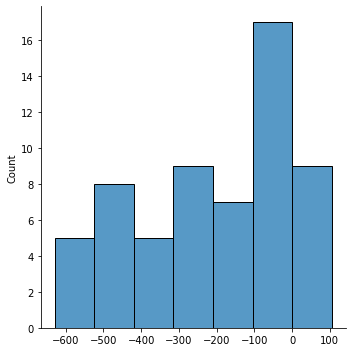

In [19]:
sns.displot(payoffs)

In [20]:
def train_model(model, epochs=10):
    print('Epoch \t FishPlayer \t HonestPlayer')
    
    for i in range(epochs):
        player1 = ThienPlayer('p1', model)
        player2 = ThienPlayer('p2', model)
        states, actions, payoffs = generate_game_session(player1, player2, max_round=1000)

        train_hole, train_community, train_stack, train_actions = select_train_data(states, actions, payoffs)
        
        model.fit(
            [train_hole, train_community, train_stack], 
            train_actions, 
            epochs=1,
            batch_size=128,
            verbose=0
        )
        
        if i % 5 == 0:
            fish = compare_players(player1, FishPlayer())
            honest = compare_players(player1, HonestPlayer())
            print(f"{i} \t {fish} \t\t {honest}")

poker_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['acc']
)

train_model(poker_model, epochs=100)

Epoch 	 FishPlayer 	 HonestPlayer
0 	 0.0 		 0.3
5 	 0.1 		 0.3
10 	 0.3 		 0.1
15 	 0.5 		 0.3
20 	 0.3 		 0.4
25 	 0.5 		 0.0
30 	 0.1 		 0.2
35 	 0.2 		 0.5
40 	 0.4 		 0.3
45 	 0.1 		 0.4
50 	 0.2 		 0.3
55 	 0.3 		 0.3
60 	 0.3 		 0.2
65 	 0.0 		 0.3
70 	 0.0 		 0.3
75 	 0.1 		 0.4
80 	 0.2 		 0.2
85 	 0.3 		 0.1
90 	 0.4 		 0.2
95 	 0.2 		 0.5


In [21]:
train_model(poker_model, epochs=1000)

Epoch 	 FishPlayer 	 HonestPlayer
0 	 0.0 		 0.5
5 	 0.3 		 0.3
10 	 0.3 		 0.3
15 	 0.2 		 0.2
20 	 0.3 		 0.2
25 	 0.3 		 0.2
30 	 0.3 		 0.3
35 	 0.1 		 0.5
40 	 0.2 		 0.6
45 	 0.2 		 0.4
50 	 0.2 		 0.2
55 	 0.5 		 0.1
60 	 0.5 		 0.5
65 	 0.3 		 0.2
70 	 0.4 		 0.3
75 	 0.4 		 0.3
80 	 0.3 		 0.4
85 	 0.1 		 0.5
90 	 0.4 		 0.3
95 	 0.9 		 0.3
100 	 0.6 		 0.3
105 	 0.3 		 0.4
110 	 0.3 		 0.2
115 	 0.3 		 0.3
120 	 0.5 		 0.2
125 	 0.6 		 0.5
130 	 0.2 		 0.2
135 	 0.2 		 0.2
140 	 0.4 		 0.4
145 	 0.4 		 0.4
150 	 0.5 		 0.2
155 	 0.4 		 0.4
160 	 0.6 		 0.4
165 	 0.2 		 0.3
170 	 0.3 		 0.2
175 	 0.4 		 0.4
180 	 0.4 		 0.1
185 	 0.4 		 0.3
190 	 0.4 		 0.4
195 	 0.5 		 0.1
200 	 0.7 		 0.2
205 	 0.6 		 0.2
210 	 0.5 		 0.4
215 	 0.2 		 0.1
220 	 0.5 		 0.5
225 	 0.3 		 0.2
230 	 0.2 		 0.2
235 	 0.3 		 0.4
240 	 0.3 		 0.3
245 	 0.3 		 0.5
250 	 0.4 		 0.4
255 	 0.4 		 0.4
260 	 0.5 		 0.3
265 	 0.3 		 0.3
270 	 0.2 		 0.4
275 	 0.4 		 0.3
280 	 0.2 		 0.3
285 	 0.1 		 0.2
29

In [30]:
player1 = ThienPlayer('p1', poker_model)

fish = compare_players(player1, FishPlayer(), max_round=20, num_sim=20)
honest = compare_players(player1, HonestPlayer(), max_round=20, num_sim=20)

print('Against FishPlayer:', fish)
print('Against HonestPlayer:', honest)

Against FishPlayer: (0.35, 1729.4285714285713, -1831.923076923077, -585.45)
Against HonestPlayer: (0.15, 799.3333333333334, -1337.4117647058824, -1016.9)


In [32]:
from datetime import datetime

time = datetime.now().strftime("%Y%m%dh%H%M%S")
poker_model.save_weights(f'saved_weights/thienplayer_{time}')